<a href="https://colab.research.google.com/github/amitmakkad/Youtube_comments_classifier/blob/main/YT_comments_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=b825048e77b5c23e8cc60f85fa8310e5f24281c68d7b2d3c0b73b95dd1a33717
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import nltk
import time
from autocorrect import Speller
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/final_data.csv",header=None)
df.drop(0)

,0,1
1,Love you sir!!,positive
2,Please make videos on..Midpoint circle drawing...,imperative
3,I bought both of your courses on Udemy. You ar...,interrogative
4,"Thank you very much, u really got me in the fi...",positive
5,i hope u are ok with everything going on again...,miscellaneous
...,...,...
9996,THIS IS GOLD! Absolute peach of a video. But I...,positive
9997,"This is helpful, how to decode a logical conte...",interrogative
9998,wow. reading this slowly actually helped me se...,positive
9999,"Great video sir, really helped a lot.keep goin...",positive


In [ ]:
df = df[df[1] != 'sentiment']

In [ ]:
df[1].unique()

array(['positive', 'imperative', 'interrogative', 'miscellaneous',
       'corrective', 'negative'], dtype=object)

In [ ]:
df = df.drop_duplicates()
df.duplicated().any()

False

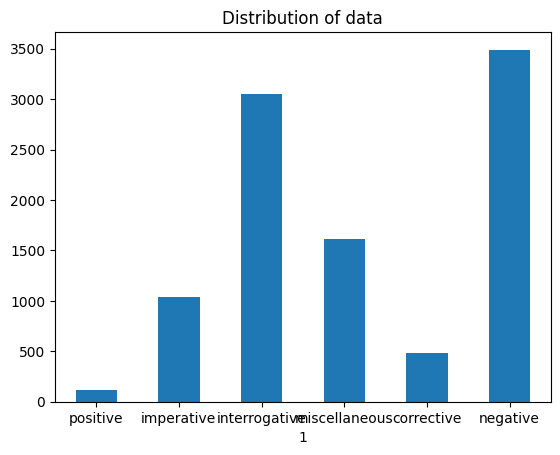

In [ ]:
# Plotting the distribution for dataset.
ax = df.groupby(1).count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['positive', 'imperative',
       'interrogative', 'miscellaneous','corrective','negative'], rotation=0)
# Storing data in lists.
text, sentiment = list(df[0]), list(df[1])

In [ ]:
# changing to lowercase
df[0] = df[0].str.lower()

# removing urls
df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)

# removing new lines "\n"
df[0] = df[0].str.replace('\n',' ', regex=True)

# removing all the punctuations
df[0] = df[0].str.replace('[^\w\s]',' ')

# removing integers
df[0] = df[0].str.replace('\d','', regex=True)

# removing emojis
df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)

In [ ]:
sentiment_mapping = {
    'positive': 0,
    'imperative': 1,
    'interrogative': 2,
    'miscellaneous': 3,
    'corrective': 4,
    'negative': 5
}
df[1] = df[1].map(sentiment_mapping)

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

df[0] = df[0].apply(lambda text: cleaning_stopwords(text))

df[0].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


1                                             love sir
2    please make videos midpoint circle drawing bre...
3    bought courses udemy talented teacher keep pro...
4    thank much u really got first video algorithm ...
5             hope u ok everything going muslims indea
Name: 0, dtype: object

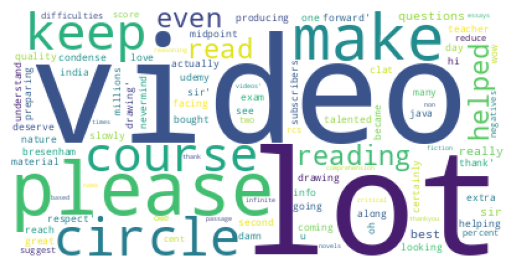

In [ ]:
from wordcloud import WordCloud
text = df[0].values

wordcloud = WordCloud(background_color='white',collocations=False).generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df[0] = df[0].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
spell = Speller(lang='en')

def typo_corrector(text):
    return spell(text)

df[0] = df[0].apply(typo_corrector)

In [ ]:
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'RandomForest': RandomForestClassifier(),
    'LinearSVC': LinearSVC(),
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier()
}
def create_pipeline(classifier):
    return Pipeline([('Normalizing', MinMaxScaler()), (classifier.__class__.__name__, classifier)])


In [ ]:
X = df[0]  # Assuming the comments are in the first column
y = df[1]  # Assuming the sentiments are in the second column

# Text preprocessing using Bag of Words (BoW) representation
count_vectorizer = CountVectorizer()
X_bow = count_vectorizer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)  # Train the classifier

    y_pred = clf.predict(X_test)  # Predict using the test set

    accuracy = accuracy_score(y_test, y_pred)  # Evaluate accuracy
    print(f"{clf_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("-------------------------")

MultinomialNB:
Accuracy: 0.6481
-------------------------
RandomForest:
Accuracy: 0.6507
-------------------------
LinearSVC:
Accuracy: 0.6410
-------------------------
LogisticRegression:
Accuracy: 0.6701
-------------------------
DecisionTree:
Accuracy: 0.5914
-------------------------


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)  # Train the classifier

    y_pred = clf.predict(X_test)  # Predict using the test set

    accuracy = accuracy_score(y_test, y_pred)  # Evaluate accuracy
    print(f"{clf_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("-------------------------")


MultinomialNB:
Accuracy: 0.6348
-------------------------
RandomForest:
Accuracy: 0.6747
-------------------------
LinearSVC:
Accuracy: 0.6757
-------------------------
LogisticRegression:
Accuracy: 0.6936
-------------------------
DecisionTree:
Accuracy: 0.5787
-------------------------


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sentences = [nltk.word_tokenize(comment.lower()) for comment in X]

# Train Word2Vec embeddings
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)

# Get Word2Vec embeddings for each comment by averaging word vectors
def generate_embedding(sentence):
    word_embeddings = [word2vec_model.wv[word] for word in nltk.word_tokenize(sentence.lower()) if word in word2vec_model.wv]
    if not word_embeddings:
        return [0] * word2vec_model.vector_size
    return sum(word_embeddings) / len(word_embeddings)

# Generate embeddings for all sentences
X_word2vec = [generate_embedding(sentence) for sentence in X]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)


# Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    pipeline = create_pipeline(clf)
    pipeline.fit(X_train, y_train)  # Train the classifier

    y_pred = pipeline.predict(X_test)  # Predict using the test set

    accuracy = accuracy_score(y_test, y_pred)  # Evaluate accuracy
    print(f"{clf_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("-------------------------")

MultinomialNB:
Accuracy: 0.4796
-------------------------
RandomForest:
Accuracy: 0.6210
-------------------------
LinearSVC:
Accuracy: 0.6307
-------------------------
LogisticRegression:
Accuracy: 0.6113
-------------------------
DecisionTree:
Accuracy: 0.4898
-------------------------


In [ ]:
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(df[0].values)
X_learn = tokenizer.texts_to_sequences(df[0].values)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

X_learn = pad_sequences(X_learn)

In [ ]:
X_learn

array([[  0,   0,   0, ...,   0,  40,   2],
       [  0,   0,   0, ...,   4,  16,   7],
       [  0,   0,   0, ...,  27,  22, 166],
       ...,
       [  0,   0,   0, ...,  63, 329,   3],
       [  0,   0,   0, ...,  26,  91, 132],
       [  0,   0,   0, ..., 400, 467,   7]], dtype=int32)

In [ ]:
y_learn=pd.get_dummies(df[1])
y_learn

,0,1,2,3,4,5
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,0,0,1,0,0,0
4,1,0,0,0,0,0
5,0,0,0,1,0,0
...,...,...,...,...,...,...
9996,1,0,0,0,0,0
9997,0,0,1,0,0,0
9998,1,0,0,0,0,0
9999,1,0,0,0,0,0


In [ ]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/glove.6B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_learn, y_learn, test_size=0.2, random_state=42)

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.random.random((len(word_index)+1,200))
for word, i in word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 200,weights=[embedding_matrix], input_shape = X_train[0].shape))
model.add(SpatialDropout1D(0.002))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(80,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(6,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 181, 200)          2122000   
                                                                 
 spatial_dropout1d (Spatial  (None, 181, 200)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 181, 100)          120400    
                                                                 
 lstm_1 (LSTM)               (None, 181, 80)           57920     
                                                                 
 lstm_2 (LSTM)               (None, 50)                26200     
                                                                 
 dense (Dense)               (None, 6)                 306       
                                                        

In [ ]:
batch_size=32
model.fit(X_train, y_train, epochs =10,steps_per_epoch=100, batch_size=batch_size, verbose = 'auto')

Epoch 1/10
100/100 [==============================] - 16s 157ms/step - loss: 1.4091 - accuracy: 0.4322
Epoch 2/10
100/100 [==============================] - 8s 82ms/step - loss: 1.1014 - accuracy: 0.5816
Epoch 3/10
100/100 [==============================] - 5s 52ms/step - loss: 0.9746 - accuracy: 0.6334
Epoch 4/10
100/100 [==============================] - 5s 46ms/step - loss: 0.9772 - accuracy: 0.6375
Epoch 5/10
100/100 [==============================] - 4s 35ms/step - loss: 0.9802 - accuracy: 0.6294
Epoch 6/10
100/100 [==============================] - 3s 26ms/step - loss: 0.8894 - accuracy: 0.6712
Epoch 7/10
100/100 [==============================] - 2s 24ms/step - loss: 0.9277 - accuracy: 0.6628
Epoch 8/10
100/100 [==============================] - 3s 28ms/step - loss: 0.8841 - accuracy: 0.6808
Epoch 9/10
100/100 [==============================] - 3s 34ms/step - loss: 0.8658 - accuracy: 0.6797
Epoch 10/10
100/100 [==============================] - 3s 34ms/step - loss: 0.8303 - accu

In [ ]:
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)

62/62 [==============================] - 2s 10ms/step


In [ ]:
y_test=y_test.to_numpy()
y_test=np.argmax(y_test,axis=1)

In [ ]:
from sklearn import metrics

# Print the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred, digits=6))

[[572  10  26  94   0   0]
 [ 30 102  41  16   0   0]
 [ 58 100 347 127   0   3]
 [ 25  16  59 208   0   3]
 [  4   2  10  11   0   0]
 [ 23   3  19  48   0   1]]
              precision    recall  f1-score   support

           0   0.803371  0.814815  0.809052       702
           1   0.437768  0.539683  0.483412       189
           2   0.691235  0.546457  0.610378       635
           3   0.412698  0.668810  0.510429       311
           4   0.000000  0.000000  0.000000        27
           5   0.142857  0.010638  0.019802        94

    accuracy                       0.628192      1958
   macro avg   0.414655  0.430067  0.405512      1958
weighted avg   0.626873  0.628192  0.616708      1958



In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

# Custom BERT model without additional embeddings
class CustomBERT(nn.Module):
    def __init__(self, bert_model):
        super(CustomBERT, self).__init__()
        self.bert = bert_model

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Process further or return the outputs

        return outputs

custom_bert= CustomBERT(bert_model).to(device)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.astype(str).tolist()
X_test = X_test.astype(str).tolist()

In [ ]:
y_train=torch.tensor(y_train.values)
y_test=torch.tensor(y_test.values)

In [ ]:
tokenized_train = tokenizer(X_train, padding=True, truncation=True, return_tensors='pt')
tokenized_test = tokenizer(X_test, padding=True, truncation=True, return_tensors='pt')

# Get the token IDs and attention masks
X_train_ids = tokenized_train['input_ids']
X_train_masks = tokenized_train['attention_mask']
X_test_ids = tokenized_test['input_ids']
X_test_masks = tokenized_test['attention_mask']


# Define the datasets
train_dataset = torch.utils.data.TensorDataset(X_train_ids, X_train_masks, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test_ids, X_test_masks, y_test)



In [ ]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(custom_bert.parameters(), lr=1e-5)


custom_bert.train()
for epoch in range(10):
    running_loss = 0.0
    total_batches = len(train_loader)
    for batch_idx, batch in enumerate(train_loader):
        inputs, masks, labels = batch
        inputs = inputs.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = custom_bert(inputs, attention_mask=masks)
        logits = outputs.last_hidden_state[:, 0, :]

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / total_batches
    print(f"Epoch {epoch + 1}, Loss: {average_loss}")

# Evaluation on test set
custom_bert.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        inputs, masks, labels = batch
        inputs = inputs.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        outputs = custom_bert(inputs, attention_mask=masks)
        logits = outputs.last_hidden_state[:, 0, :]
        _, predicted = torch.max(logits, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy}")


Epoch 1, Loss: 1.3220213457995533
Epoch 2, Loss: 0.8646713964915852
Epoch 3, Loss: 0.5768157337208804
Epoch 4, Loss: 0.36311866716304225
Epoch 5, Loss: 0.21327596505782578
Epoch 6, Loss: 0.15298189984113103
Epoch 7, Loss: 0.11581721108252603
Epoch 8, Loss: 0.09425166014990859
Epoch 9, Loss: 0.0863807827382575
Epoch 10, Loss: 0.07647898026488842
Accuracy on test set: 0.6598569969356486
